# Initialisation

In [122]:
import os
import torch
os.environ['TORCH'] = torch.__version__
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Dataframe_Labels = pd.read_csv("../../BLCA_DATA/Workspace/labels_str.csv")
Dataframe_link = pd.read_csv("../../BLCA_DATA/Workspace/patient_norm.csv")
Dataframe_node= pd.read_csv("../../BLCA_DATA/Workspace/node_embedding.csv")

Dataframe_Labels['class_int'], uniques = pd.factorize(Dataframe_Labels['class'])
Dataframe_Labels

,Patient,class,class_int
0,TCGA-2F-A9KO,LumP,0
1,TCGA-2F-A9KP,LumP,0
2,TCGA-2F-A9KQ,LumP,0
3,TCGA-2F-A9KR,Ba/Sq,1
4,TCGA-2F-A9KT,Ba/Sq,1
...,...,...,...
399,TCGA-ZF-AA56,Ba/Sq,1
400,TCGA-ZF-AA58,Ba/Sq,1
401,TCGA-ZF-AA5H,Ba/Sq,1
402,TCGA-ZF-AA5N,LumP,0


# Mise en place des arretes, noeuds et leur poids

In [123]:
classes_dict = {0: 'LumP', 
                1: 'Ba/Sq', 
                2: 'LumU', 
                3: 'Stroma-rich', 
                4: 'LumNS', 
                5: 'NE-like'
}

def count_classes_weights(tensor):
    array = tensor.numpy()
    classes_tab = { 0: 0, 
                    1: 0,
                    2: 0, 
                    3: 0, 
                    4: 0,
                    5: 0
    }
    for i in array:
        classes_tab[i]+=1

    mean_nb_classes = 0
    for i in classes_tab:
        mean_nb_classes += i
    mean_nb_classes *= 1/len(classes_tab)
    
    # normalize the weights
    weight_sum = 0
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_sum += mean_nb_classes / classes_tab[i]
    alpha = 1 / weight_sum

    weight_dict = {}
    used_classes = []
    for i in range(len(classes_tab)):
        if classes_tab[i] != 0:
            weight_dict[i] = alpha * (mean_nb_classes / classes_tab[i]) *50
            used_classes.append(classes_dict[i])

    return used_classes, weight_dict

# 2eme GATv2 - Avec mise à jour des poids des classes

In [124]:
node_features = Dataframe_node.drop(columns=['Patient']).values
node_features = torch.tensor(node_features, dtype=torch.float)

def get_data(indices, similarity_threshold, Dataframe_link, Dataframe_Labels, num_classes=6):
    x_data = node_features[indices]

    patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])
    similarity_threshold = 0.5  # Exemple de seuil de similarité    

    # Calculate the edges and attention ridges for training
    edge_index = []
    edge_attr = []
    re_indexed_i = 0
    re_indexed_j = 0
    for i in indices:
        for j in indices:
            if i >= j :
                break
            if patient_similarity[i, j] > similarity_threshold:
                edge_index.append([re_indexed_i, re_indexed_j])
                edge_attr.append((patient_similarity[i, j] - similarity_threshold)/(1 - similarity_threshold))
            re_indexed_j +=1
        re_indexed_i +=1
        re_indexed_j = 0

    node_labels = Dataframe_Labels["class_int"].values
    labels = torch.tensor(node_labels[indices], dtype=torch.long)

    node_labels = torch.tensor(node_labels, dtype=torch.long)

    used_classes, weight_dict = count_classes_weights(node_labels)
    Dataframe_Labels['weight'] = [weight_dict[x] for x in Dataframe_Labels['class_int']]
    node_weights = torch.tensor(Dataframe_Labels['weight'], dtype=torch.float)

    edge_features = torch.tensor(x_data, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.int64).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_weights = node_weights[indices]

    data = Data(
    x=edge_features, 
    edge_index=edge_index, 
    edge_attr=edge_attr, 
    y=labels, 
    weights=node_weights, 
    num_classes=num_classes,
    num_nodes = len(edge_features),
    num_features = edge_features.shape[1],
    indices = indices)

    return data


In [125]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sn

class GATv2(torch.nn.Module):
    def __init__(self, hidden_channels, heads, data):
        super(GATv2, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GATv2Conv(data.num_features, hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATv2Conv(hidden_channels * heads, data.num_classes, edge_dim=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

def weighted_cross_entropy_loss(output, target, weights):
    loss = F.cross_entropy(output, target, reduction='none')
    weighted_loss = loss * weights[target]
    return weighted_loss.mean()

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = weighted_cross_entropy_loss(out[data.train_mask], data.y[data.train_mask], data.weights[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, model

def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc, pred[mask]

# Training on 1 graph

In [126]:
def cross_validation_one_graph(data, k_folds, hidden_channels, heads, num_epochs=1000):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    best_acc = 0 

    for fold, (train_index, val_index) in enumerate(skf.split(data.x, data.y)):

        print(len(train_index))
        print(len(val_index))

        # Define masks
        data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.train_mask[train_index] = True
        
        data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        data.val_mask[val_index] = True
        
        train_classes, _ = count_classes_weights(data.y[data.train_mask])
        val_classes, _ = count_classes_weights(data.y[data.val_mask])

        print(val_classes, len(val_classes))

            # Initialize model, optimizer, and loss function
        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        lost_function_compil = []
        all_val_acc_plot = []

        # Training loop
        for epoch in range(1, num_epochs):
            loss, model = train(model, data, optimizer)
            train_acc, _ = test (model, data, data.train_mask)
            val_acc, _ = test(model, data, data.val_mask)
            lost_function_compil.append(loss.detach().tolist())
            all_val_acc_plot.append(val_acc)

            print(f'Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        # Evaluate on validation set
        val_acc, y_pred = test(model, data, data.val_mask)
        y_true = data.y[data.val_mask]

        if val_acc > best_acc:
            best_model = model

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

        # Plot confusion matrix
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=val_classes, columns=val_classes)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model, mean_val_acc

258
65
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)


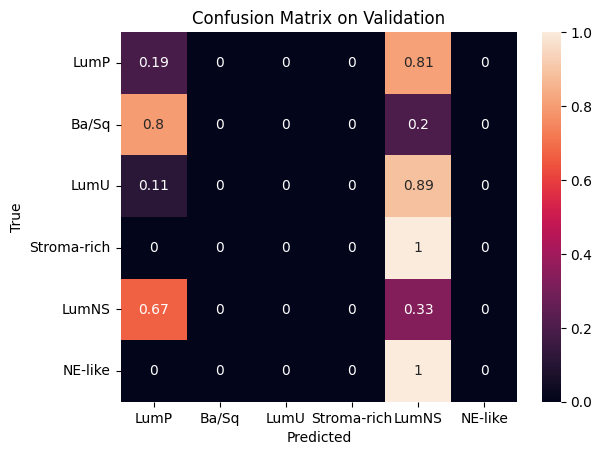

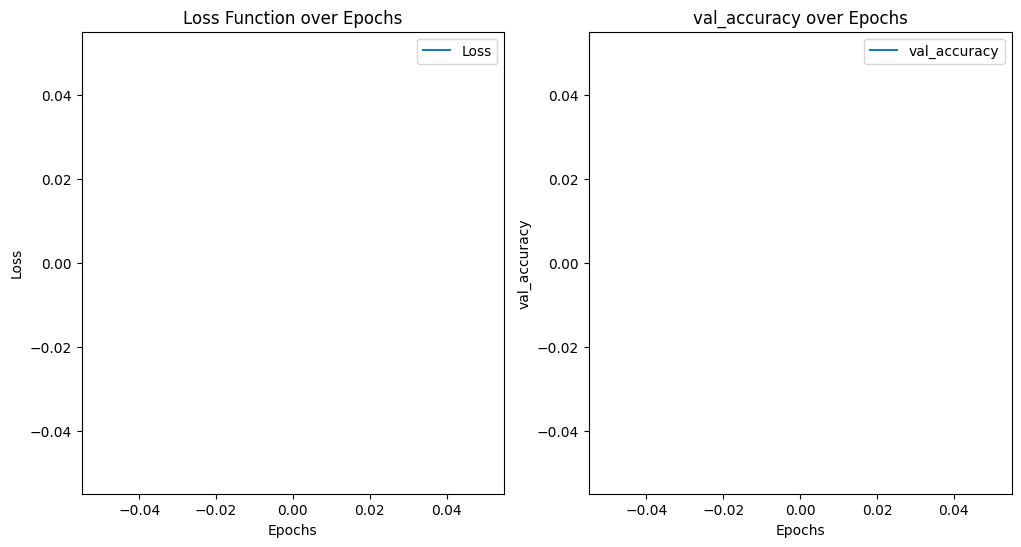

258
65
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


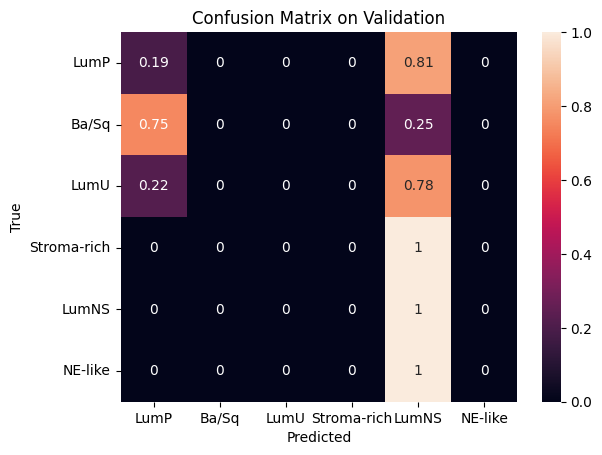

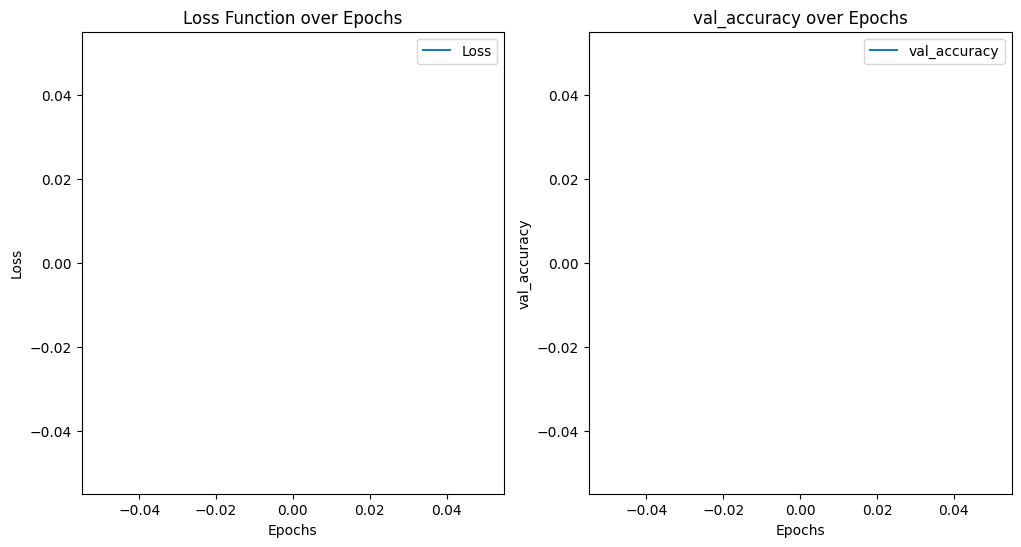

258
65
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


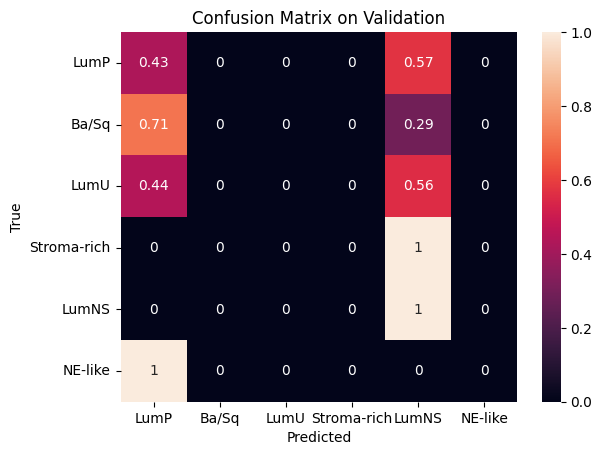

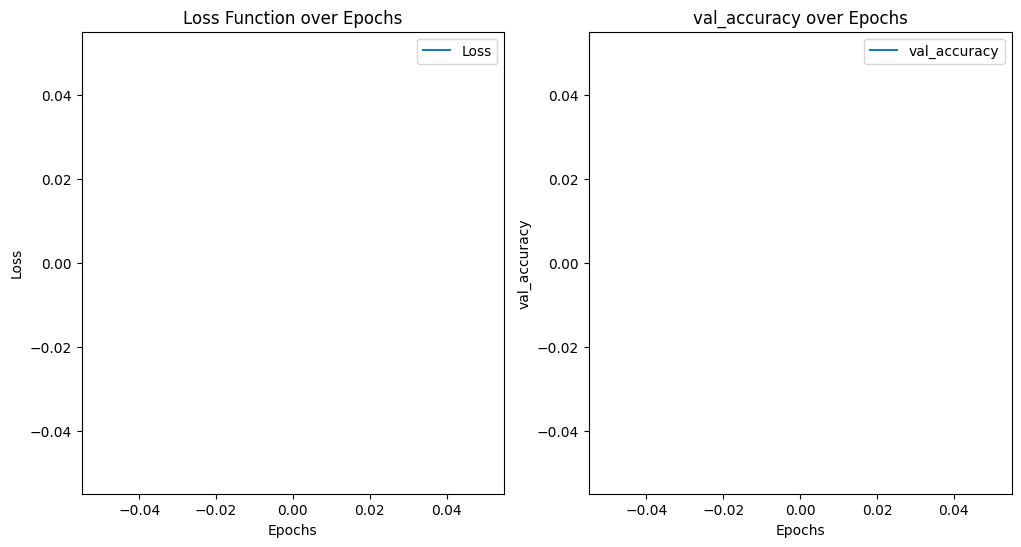

259
64
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


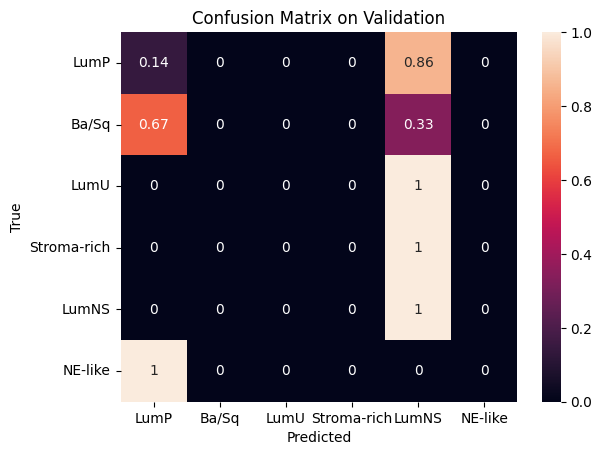

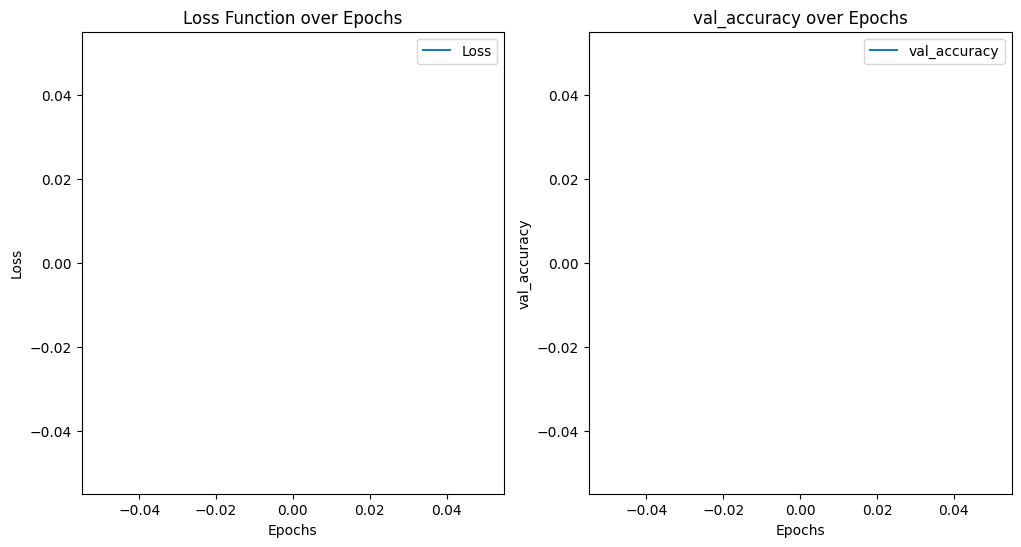

259
64
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like'] 6


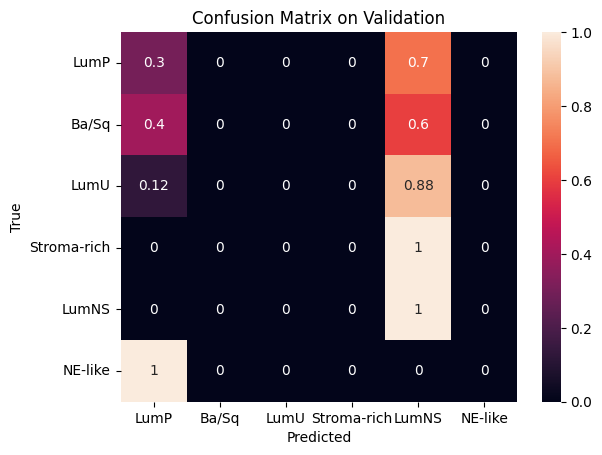

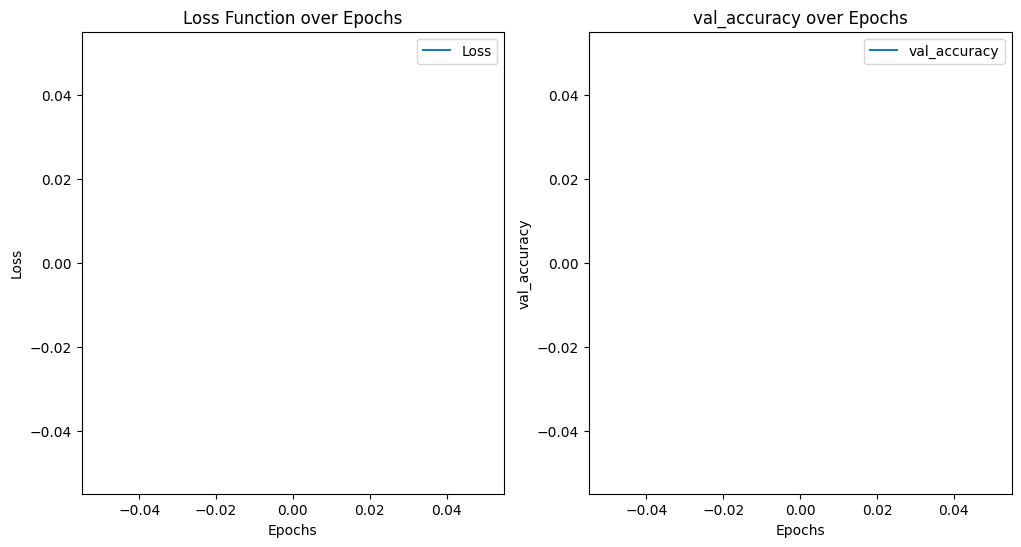

Mean Validation Accuracy: 0.1207, Std Validation Accuracy: 0.0382


In [127]:
from sklearn.model_selection import train_test_split

similarity_threshold = 0.5

train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=0.2, 
    random_state=1234
)

train_val_data = get_data(train_val_indices, similarity_threshold, Dataframe_link, Dataframe_Labels, num_classes=6)
test_data = get_data(test_indices, similarity_threshold, Dataframe_link, Dataframe_Labels, num_classes=6)

best_model, mean_val_acc = cross_validation_one_graph(train_val_data, k_folds=5, hidden_channels=20, heads=8, num_epochs=1)

Test accuracy: 0.1235


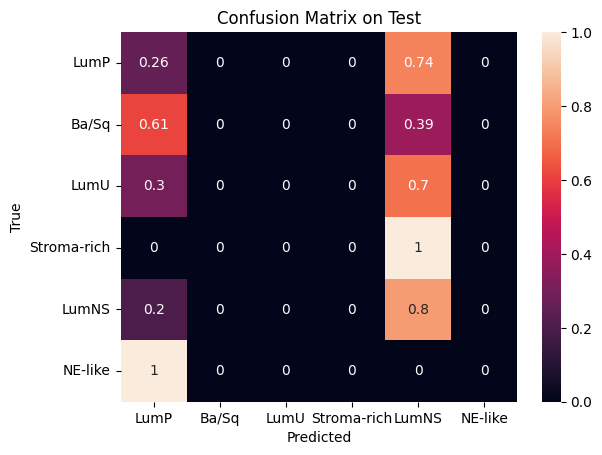

In [128]:
test_mask = torch.ones(test_data.num_nodes, dtype=torch.bool)

test_acc, y_pred = test(best_model, test_data, test_mask)
y_true = test_data.y[test_mask]

conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

print(f'Test accuracy: {test_acc:.4f}')

classes = ('LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS', 'NE-like')
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_matrix_normalized, index=classes, columns=classes)  
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test')
plt.show()

# Training with several graphs : Induction

In [132]:
from sklearn.model_selection import train_test_split
import numpy as np

similarity_threshold = 0.5
test_size = 0.2
n_graphs = 5  # Nombre de divisions souhaitées pour train_val_indices

# Étape 1: Diviser les indices en ensembles train/validation et test
train_val_indices, test_indices = train_test_split(
    range(len(node_features)), 
    test_size=test_size, 
    random_state=1234
)

# Étape 2: Diviser train_val_indices en n listes d'indices
def split_indices(indices, n_graphs):
    np.random.shuffle(indices)  # Mélanger les indices pour une division plus aléatoire
    return np.array_split(indices, n_graphs)

# Appliquer la fonction de division
split_train_val_indices = split_indices(train_val_indices, n_graphs)

# Affichage des résultats
for i, indices in enumerate(split_train_val_indices):
    print(f"Subset {i+1}: {indices}, {len(indices)}")


Subset 1: [169  80  68 149  41 268 393 335 297 224 336 241  81  15 374 186 246  23
 287 298 325 340 181 237 191 164  76 346 157  30  38 350 371  37  50  31
 155 206 320 212 141 274  28 318 377   6 242  47  95 109 244  27  33 355
  60 110  20  53 400  52 375 137 175 358 301], 65
Subset 2: [376  46 139 395 372 140 105  90 203 402 178 359 270 135 111  69 378 201
 142  86 283 129 215 194 132 234 235 126  61 103 188  83 231 196  19 288
 123  54 117 282 182 303 337  56 150 267 380  18 228  88 379 198 390 365
 399 392 106   8 266  42 202 360 349 171  75], 65
Subset 3: [321 217 368 125 370 225  89  65 309 151 127 195 180 216 313 306 114 214
 130 113   4  98 159 328 108 251 256 369 290 331  93 382 345  79 211 373
 277 275 324 262 291 233 401   9 170 163 316 189 236  63 116 293 238 107
 354 143  17 391  48   2 176 209 330 173 398], 65
Subset 4: [183 334 385 260  77 134 319 258 204  16 102 366 158 252 207 263  96   3
 172 257  35 250 387  87 174 208 197 384 343  26 300 381 307 122 147  32
 299 16

In [130]:
def cross_validation_induction(data, k_folds, hidden_channels, heads, num_epochs=1000):

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1234)
    all_val_acc = []

    best_acc = 0 

    for fold, (_, _) in enumerate(skf.split(data.x, data.y)):
        
        split_train_val_indices = split_indices(data.indices, n_graphs)
        graph = 1
        data_graph = get_data(split_train_val_indices[0], similarity_threshold, Dataframe_link, Dataframe_Labels, num_classes=6)

        model = GATv2(hidden_channels=hidden_channels, heads=heads, data=data_graph)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        # Appliquer la fonction de division
        for node_in_each_graph in split_train_val_indices:

            data_graph = get_data(node_in_each_graph, similarity_threshold, Dataframe_link, Dataframe_Labels, num_classes=6)

            # Étape 1: Diviser les indices en ensembles train/validation et test
            train_index, val_index = train_test_split(
                range(len(node_in_each_graph)), 
                test_size=0.2, 
                random_state=1234
            )

            # Define masks
            data_graph.train_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.train_mask[train_index] = True
            
            data_graph.val_mask = torch.zeros(data_graph.num_nodes, dtype=torch.bool)
            data_graph.val_mask[val_index] = True
        
            train_classes, _ = count_classes_weights(data_graph.y[data_graph.train_mask])
            val_classes, _ = count_classes_weights(data_graph.y[data_graph.val_mask])

            print(val_classes, len(val_classes))

            # Initialize model, optimizer, and loss function


            lost_function_compil = []
            all_val_acc_plot = []

            # Training loop
            for epoch in range(1, num_epochs):
                loss, model = train(model, data_graph, optimizer)
                train_acc, _ = test (model, data_graph, data_graph.train_mask)
                val_acc, _ = test(model, data_graph, data_graph.val_mask)
                lost_function_compil.append(loss.detach().tolist())
                all_val_acc_plot.append(val_acc)
                if epoch % 100 == 0:
                    print(f'Graph: {graph}, Fold: {fold + 1}, Epoch: {epoch:03d}, Loss: {loss:.4f}, Train_acc {train_acc:.4f}, Val_acc {val_acc:.4f}')

        graph += 1

        # Evaluate on validation set
        val_acc, y_pred = test(model, data_graph, data_graph.val_mask)
        y_true = data_graph.y[data_graph.val_mask]

        if val_acc > best_acc:
            best_model = model

        # Store results
        all_val_acc.append(val_acc)
        conf_matrix = confusion_matrix(y_true.cpu().tolist(), y_pred.cpu().tolist())

        # Plot confusion matrix
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        df_cm = pd.DataFrame(conf_matrix_normalized, index=val_classes, columns=val_classes)  
        sn.heatmap(df_cm, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix on Validation')
        plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.plot(range(len(lost_function_compil)), lost_function_compil, label='Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss Function over Epochs')
        ax1.legend()

        ax2.plot(range(len(all_val_acc_plot)), all_val_acc_plot, label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('val_accuracy')
        ax2.set_title('val_accuracy over Epochs')
        ax2.legend()

        plt.show()

    # Calculate and print overall metrics
    mean_val_acc = np.mean(all_val_acc)
    std_val_acc = np.std(all_val_acc)
    print(f'Mean Validation Accuracy: {mean_val_acc:.4f}, Std Validation Accuracy: {std_val_acc:.4f}')

    return best_model, mean_val_acc

In [131]:
best_model, mean_val_acc = cross_validation_induction(train_val_data, k_folds=5, hidden_channels=20, heads=8, num_epochs=1)

['LumP', 'Ba/Sq', 'LumU', 'NE-like'] 4
['LumP', 'Ba/Sq', 'LumU', 'LumNS'] 4
['LumP', 'LumU', 'Stroma-rich', 'LumNS'] 4
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich', 'LumNS'] 5
['LumP', 'Ba/Sq', 'LumU', 'Stroma-rich'] 4


/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_features = torch.tensor(x_data, dtype=torch.float)
/tmp/ipykernel_47898/3194484565.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTenso

ValueError: Shape of passed values is (5, 5), indices imply (4, 4)